<a href="https://colab.research.google.com/github/ahmedtarek-/MNS_CP_2022/blob/main/stochastic_channel/Stochastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# H-H-He-He-He-Hel-Hell-Hello Stochastic


## 1.1) Defining the potassium channel object

In [ ]:
from random import uniform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

K_REVERSAL = -77        # mV
K_CONDUC = 36*10**-6    # Siemens (should've been ^-9 but multiplied with 1000 to compensate for using milli votls)

class StochasticKChannel:
  def __init__(self, initial_state=1, voltage=-50, delta_t=0.1):
    self.state = initial_state
    self.voltage = voltage
    self.delta_t = delta_t

  def update_voltage(self, voltage):
    self.voltage = voltage

  def update_delta_t(self, delta_t):
    self.delta_t = delta_t

  def alpha_n(self):
    alpha = (0.01* (self.voltage +  55)) / (1 - np.exp(-0.1 * (self.voltage + 55) ))
    # print("Alpha: {}".format(alpha))
    return alpha * self.delta_t

  def beta_n(self):
    beta = 0.125 * np.exp(-0.0125 * (self.voltage + 65) )
    # print("Beta: {}".format(beta))
    return beta * self.delta_t

  def k_current(self):
    """
    The next line is based on n (HH model)
      return K_CONDUC * prob**4 * (self.voltage - K_REVERSAL)
    What we want though is current based on P (is channel open or no)
    """
    return K_CONDUC * self.P() * (self.voltage - K_REVERSAL)

  def state_1_transition(self):
    """
      Probability to leave and go to S2: 4*alpha_n
    """
    random_1 = uniform(0, 1)
    p_leave = 4*self.alpha_n()
    # print("Prob to leave state 1: {} (rand: {})".format(p_leave, random_1))
    if random_1 <= p_leave:
      self.state = 2
      return True
    return False

  def state_2_transition(self):
    """
      Probability to leave: 3*alpha_n + beta_n
      Probability to go to S3: 3*alpha_n / (3*alpha_n + beta_n)
      Probability to go to S1: 1- (3*alpha_n / (3*alpha_n + beta_n))
    """
    random_1 = uniform(0, 1)
    random_2 = uniform(0, 1)
    p_leave = 3*self.alpha_n() + self.beta_n()
    p_s3 = 3*self.alpha_n() / (3*self.alpha_n() + self.beta_n())
    if random_1 > p_leave:
      return False  # Stay in state 1
    if random_2 <= p_s3:
      self.state = 3
    else:
      self.state = 1
    return True

  def state_3_transition(self):
    random_1 = uniform(0, 1)
    random_2 = uniform(0, 1)
    p_leave = 2*self.alpha_n() + 2*self.beta_n()
    p_s4 = 2*self.alpha_n() / (2*self.alpha_n() + 2*self.beta_n())
    if random_1 > p_leave:
      return False  # Stay in state 1
    if random_2 <= p_s4:
      self.state = 4
    else:
      self.state = 2
    return True

  def state_4_transition(self):
    random_1 = uniform(0, 1)
    random_2 = uniform(0, 1)
    p_leave = self.alpha_n() + 3*self.beta_n()
    p_s5 = self.alpha_n() / (self.alpha_n() + 3*self.beta_n())
    if random_1 > p_leave:
      return False  # Stay in state 1
    if random_2 <= p_s5:
      self.state = 5
    else:
      self.state = 3
    return True

  def state_5_transition(self):
    random_1 = uniform(0, 1)
    if random_1 <= 4*self.beta_n():
      self.state = 4
      return True
    return False

  def P(self):
    if self.state == 5:
      return 1
    else:
      return 0

  def next_state(self):
    if self.state == 1:
      self.state_1_transition()
    elif self.state ==  2:
      self.state_2_transition()
    elif self.state == 3:
      self.state_3_transition()
    elif self.state == 4:
      self.state_4_transition()
    elif self.state ==  5:
      self.state_5_transition()
    return self.P()

  def go_stochastic(self, t_max=0, delta_t=0):
    self.delta_t = delta_t
    t = delta_t
    on_off = []
    while t <= t_max:
      on_off.append(self.P())
      self.next_state()
      t += delta_t
    return on_off

channel = StochasticKChannel(initial_state=1, voltage=10)
print("initial: {}".format(channel.state))
channel.next_state()
print("after one move: {}".format(channel.state))

initial: 1
after one move: 1


## 1.2) Trying out the Stochastic time relation

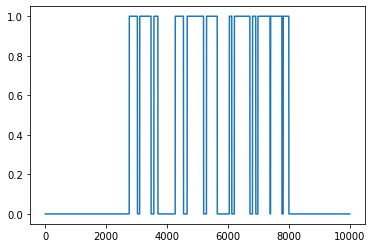

In [ ]:
t_max   = 20      # 20 mS
delta_t = 0.01
channel = StochasticKChannel(initial_state=1, voltage=-100)
output_i = channel.go_stochastic(t_max=20, delta_t=delta_t)

channel = StochasticKChannel(initial_state=1, voltage=10)
output_ii = channel.go_stochastic(t_max=60, delta_t=delta_t)

channel = StochasticKChannel(initial_state=1, voltage=-100)
output_iii = channel.go_stochastic(t_max=20, delta_t=delta_t)

outputs = output_i + output_ii + output_iii


plt.plot(outputs)
plt.show()

### 1.3) Defining a population class

In [ ]:
class StochasticPopulation:
  def __init__(self, k_population=[], na_population=[], initial_voltage=0, delta_t=0):
    self.k_population = k_population
    self.na_population = na_population
    self.voltage = initial_voltage
    self.delta_t = delta_t
    for channel in (self.k_population + self.na_population):
        channel.update_voltage(self.voltage)
        channel.update_delta_t(self.delta_t)

  def go_stochastic(self, t_max=0):
    t = 0
    on_off_k = []
    on_off_na = []
    while t <= t_max:
      open_k_channels = 0
      open_na_channels = 0
      for k_channel in self.k_population:
        open_k_channels += k_channel.next_state()
      for na_channel in self.na_population:
        open_na_channels += na_channel.next_state()
      if len(self.k_population) != 0:
        mean_open_k = open_k_channels / len(self.k_population)
        on_off_k.append(mean_open_k)
      if len(self.na_population) != 0:
        mean_open_na = open_na_channels / len(self.na_population)
        on_off_na.append(mean_open_na)
      # Update voltage here using current calculated from above
      t += delta_t
    return on_off_k, on_off_na


## 1.4) Calculating and plotting the variance over different populations (k)
We also plot the ON/OFF mean of channels (against the n(inf) which is our expec ted mean).   

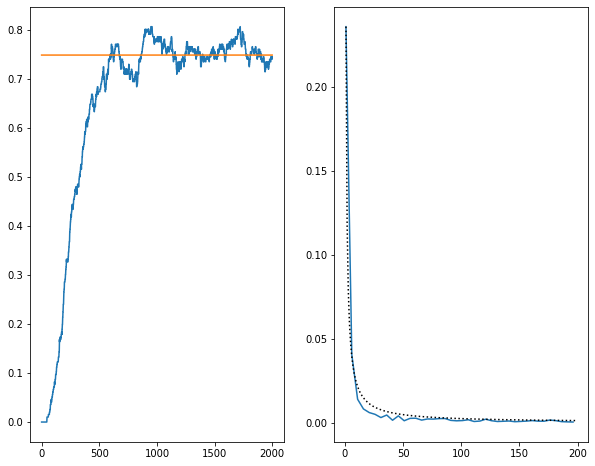

In [ ]:
def alpha_n(voltage):
  alpha = (0.01* (voltage +  55)) / (1 - np.exp(-0.1 * (voltage + 55) ))
  # print("Alpha: {}".format(alpha))
  return alpha

def beta_n(voltage):
  beta = 0.125 * np.exp(-0.0125 * (voltage + 65) )
  # print("Beta: {}".format(beta))
  return beta

def n_inf(voltage):
  n_inf = alpha_n(voltage) / (alpha_n(voltage) + beta_n(voltage))
  return n_inf

def tao(voltage):
  return 1 / (alpha_n(voltage) + beta_n(voltage))

voltage = 10
delta_t = 0.01

k_population = [StochasticKChannel(initial_state=1) for x in range(100)]
stochastic_pop = StochasticPopulation(k_population=k_population, initial_voltage=voltage, delta_t=delta_t)
avgs_100 = stochastic_pop.go_stochastic(t_max=20)[0]

n_inf_line = [n_inf(10)**4 for x in range(len(avgs_100))]

ns = np.arange(1,200, 5)
variances = []
for n in ns:  
  outputs = []
  k_population = [StochasticKChannel(initial_state=1) for x in range(n)]
  stochastic_pop = StochasticPopulation(k_population=k_population, initial_voltage=voltage, delta_t=delta_t)
  avgs = stochastic_pop.go_stochastic(t_max=20)[0]
  variances.append(np.var(avgs[1000:]))

n_inf_line = [n_inf(10)**4 for x in range(len(avgs))]
expected_varaince = [variances[0]/N for N in range(200)] 

# Plotting
figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(avgs)
plt.plot(n_inf_line)

plt.subplot(1,2,2)
plt.plot(ns, variances)
plt.plot(range(200), expected_varaince, ls=":", c="k")

## 2) Defining the Sodium channel object

In [ ]:
class StochasticNAChannel:
  k1_rate = 0.24        # 1/ms
  k3_rate = 1.5         # 1/ms
  k2_rate = 0.4         # 1/ms

  def __init__(self, initial_state=1, voltage=-50, delta_t=0.1):
    self.state = initial_state
    self.voltage = voltage
    self.delta_t = delta_t

  def update_voltage(self, voltage):
    self.voltage = voltage

  def update_delta_t(self, delta_t):
    self.delta_t = delta_t

  def alpha_m(self):
    alpha = (0.1* (self.voltage +  40)) / (1 - np.exp(-0.1 * (self.voltage + 40) ))
    return alpha * self.delta_t

  def beta_m(self):
    beta = 4 * np.exp(-0.0556 * (self.voltage + 65) )
    return beta * self.delta_t

  def alpha_h(self):
    alpha = 0.07*np.exp(-0.05 * (self.voltage + 65))
    return alpha * self.delta_t

  def beta_h(self):
    beta = 1 / (1 + np.exp(-0.1 * (self.voltage + 35) ))
    return beta * self.delta_t

  def k1(self):
    return self.k1_rate * self.delta_t

  def k2(self):
    return self.k2_rate * self.delta_t
  
  def k3(self):
    return self.k3_rate * self.delta_t

  def state_1_transition(self):
    """
      Probability to leave and go to S2: 3*alpha_m
    """
    random_1 = uniform(0, 1)
    p_leave = 3*self.alpha_m()
    # print("Prob to leave state 1: {} (rand: {})".format(p_leave, random_1))
    if random_1 <= p_leave:
      self.state = 2
      return True
    return False

  def state_2_transition(self):
    """
      Probability to leave: 3*alpha_n + beta_n
      Probability to go to S3: 3*alpha_n / (3*alpha_n + beta_n)
      Probability to go to S1: 1- (3*alpha_n / (3*alpha_n + beta_n))
    """
    random_1 = uniform(0, 1)
    p_leave = 2*self.alpha_m() + self.beta_m() + self.k1()
    if random_1 > p_leave:
      return False                                            # Stay in state 2
    p_s3 = 2*self.alpha_m() / p_leave
    p_s1 = (self.beta_m() + 2*self.alpha_m()) / p_leave
    random_2 = uniform(0, 1)
    if random_2 <= p_s3:
      self.state = 3
    elif random_2 <= p_s1:
      self.state = 1
    else:
      self.state = 5
    return True

  def state_3_transition(self):
    random_1 = uniform(0, 1)
    p_leave = self.alpha_m() + 2*self.beta_m() + self.k2()
    if random_1 > p_leave:
      return False                                             # Stay in state 3
    p_s4 = self.alpha_m() / p_leave
    p_s2 = (2*self.beta_m() + self.alpha_m()) / p_leave
    random_2 = uniform(0, 1)
    if random_2 <= p_s4:
      self.state = 4
    elif random_2 <= p_s2:
      self.state = 2
    else:
      self.state = 5
    return True

  def state_4_transition(self):
    random_1 = uniform(0, 1)
    p_leave = self.k3() + 3*self.beta_m()
    if random_1 > p_leave:
      return False                                             # Stay in state 1
    random_2 = uniform(0, 1)
    p_s5 = self.k3() / p_leave
    if random_2 <= p_s5:
      self.state = 5
    else:
      self.state = 3
    return True

  def state_5_transition(self):
    random_1 = uniform(0, 1)
    if random_1 <= self.alpha_h():
      self.state = 3
      return True
    return False

  def P(self):
    if self.state == 4:
      return 1
    else:
      return 0

  def next_state(self):
    if self.state == 1:
      self.state_1_transition()
    elif self.state ==  2:
      self.state_2_transition()
    elif self.state == 3:
      self.state_3_transition()
    elif self.state == 4:
      self.state_4_transition()
    elif self.state ==  5:
      self.state_5_transition()
    return self.P()

  def go_stochastic(self, t_max=0, delta_t=0):
    self.delta_t = delta_t
    t = delta_t
    on_off = []
    while t <= t_max:
      on_off.append(self.P())
      self.next_state()
      t += delta_t
    return on_off

channel = StochasticNAChannel(initial_state=1, voltage=10, delta_t=0.01)
print("initial: {}".format(channel.state))
channel.next_state()
print("after one transition: {}".format(channel.state))

# Do we need to distinguish between closed and inactive states?


initial: 1
after one transition: 1


#### 2.1) Calculating and plotting the behaviour of one NA channel

calculated mean = 0.0008000160003200064
expected mean = 0.0016020252408374166


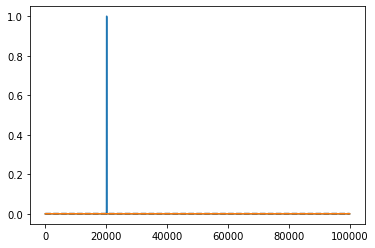

1.0768704938599587


In [ ]:
t_max   = 20      # 20 mS
delta_t = 0.001
channel = StochasticNAChannel(initial_state=1, voltage=-100)
output_i = channel.go_stochastic(t_max=20, delta_t=delta_t)

channel = StochasticNAChannel(initial_state=1, voltage=10)
output_ii = channel.go_stochastic(t_max=60, delta_t=delta_t)

channel = StochasticNAChannel(initial_state=1, voltage=-100)
output_iii = channel.go_stochastic(t_max=20, delta_t=delta_t)

outputs = output_i + output_ii + output_iii

def alpha_m(voltage):
  alpha = (0.1* (voltage +  40)) / (1 - np.exp(-0.1 * (voltage + 40) ))
  # print("Alpha: {}".format(alpha))
  return alpha

def beta_m(voltage):
  beta = 4 * np.exp(-0.0556 * (voltage + 65) )
  # print("Beta: {}".format(beta))
  return beta

def alpha_h(voltage):
  alpha = 0.07*np.exp(-0.05 * (voltage + 65))
  # print("Alpha: {}".format(alpha))
  return alpha
  
def beta_h(voltage):
  beta = 1 / (1 + np.exp(-0.1 * (voltage + 35) ))
  # print("Beta: {}".format(beta))
  return beta

def m_inf(voltage):
  m_inf = alpha_m(voltage) / (alpha_m(voltage) + beta_m(voltage))
  return m_inf

def tao_m(voltage):
  return 1 / (alpha_m(voltage) + beta_m(voltage))

def h_inf(voltage):
  h_inf = alpha_h(voltage) / (alpha_h(voltage) + beta_h(voltage))
  return h_inf

def tao_h(voltage):
  return 1 / (alpha_h(voltage) + beta_h(voltage))

expected_mean=[m_inf(10)**3*h_inf(10) for x in range(100000)]
mean=np.mean(outputs)
mean_calculated=[mean for x in range(100000)]
print(f'calculated mean = {mean}')
print(f'expected mean = {expected_mean[0]}')

#I think the difference in means is quite large but then again I am not sure as it changes every time
#sometimes we have good numbers and other times our prediction is larger than the expected one
plt.plot(outputs)
plt.plot(expected_mean, ls='--', c='k')
plt.plot(mean_calculated)
#plt.plot(tao_h)
plt.show()
print(tao_h(-10))

#### 2.2) Variance, mean for a population of NA channels

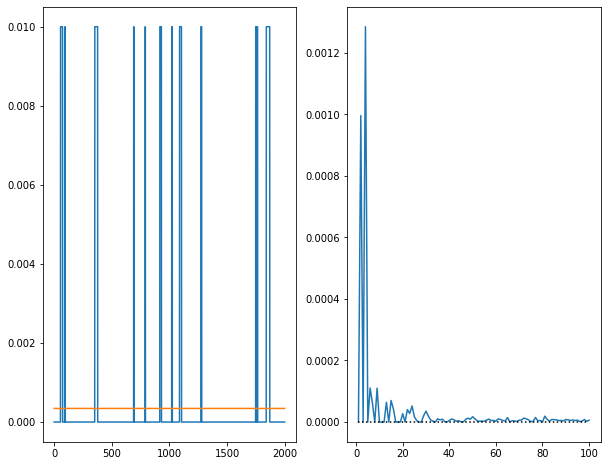

In [ ]:
def alpha_m(voltage):
  alpha = (0.1* (voltage +  40)) / (1 - np.exp(-0.1 * (voltage + 40) ))
  # print("Alpha: {}".format(alpha))
  return alpha

def beta_m(voltage):
  beta = 4 * np.exp(-0.0556 * (voltage + 65) )
  # print("Beta: {}".format(beta))
  return beta

def alpha_h(voltage):
  alpha = 0.07*np.exp(-0.05 * (voltage + 65))
  # print("Alpha: {}".format(alpha))
  return alpha
  
def beta_h(voltage):
  beta = 1 / (1 + np.exp(-0.1 * (voltage + 35) ))
  # print("Beta: {}".format(beta))
  return beta

def m_inf(voltage):
  m_inf = alpha_m(voltage) / (alpha_m(voltage) + beta_m(voltage))
  return m_inf

def tao_m(voltage):
  return 1 / (alpha_m(voltage) + beta_m(voltage))

def h_inf(voltage):
  h_inf = alpha_h(voltage) / (alpha_h(voltage) + beta_h(voltage))
  return h_inf

def tao_h(voltage):
  return 1 / (alpha_h(voltage) + beta_h(voltage))

voltage = -60
delta_t = 0.01

na_population = [StochasticNAChannel(initial_state=1) for x in range(100)]
stochastic_pop = StochasticPopulation(na_population=na_population, initial_voltage=voltage, delta_t=delta_t)
avgs_100 = stochastic_pop.go_stochastic(t_max=20)[1]

ns = np.arange(1,101, 1)
variances = []
for n in ns:  
  outputs = []
  na_population = [StochasticNAChannel(initial_state=1) for x in range(n)]
  stochastic_pop = StochasticPopulation(na_population=na_population, initial_voltage=voltage, delta_t=delta_t)
  avgs = stochastic_pop.go_stochastic(t_max=20)[1]
  variances.append(np.var(avgs[1000:]))

mh_inf_line = [m_inf(voltage)**3*h_inf(voltage) for x in range(len(avgs))]
expected_varaince = [variances[0]/N for N in range(100)] 

# Plotting
figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(avgs)
plt.plot(mh_inf_line)

plt.subplot(1,2,2)
plt.plot(ns, variances)
plt.plot(range(100), expected_varaince, ls=":", c="k")
plt.show()


1.4287155038424852

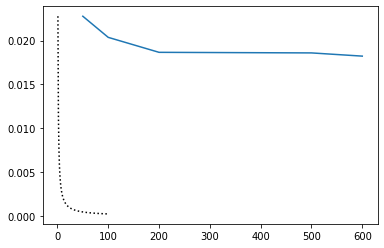

In [ ]:

voltage = 10
delta_t = 0.01
ns = [50,100,200,500,600]
variances = []
for n in ns:  
  outputs = []
  for x in range(n):
    channel = StochasticKChannel(initial_state=1, voltage=voltage)
    outputs.append(channel.go_stochastic(t_max=60, delta_t=delta_t))
  avgs = np.mean(np.array(outputs), axis=0)
  variances.append(np.var(avgs))

n_inf_line = [n_inf(10)**4 for x in range(int(t_max/delta_t))]
expected_varaince = [variances[0]/N for N in range(100)] 
plt.plot(ns, variances)
plt.plot(range(100), expected_varaince, ls=":", c="k")
tao(voltage)